# 1- Introduction

## 1.1 Problem statement

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster.

THe challenge is to build an NLP model to predict whether a Tweet is actually describing real emergency or not

## 1.2 Load the packages

In [61]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords 

import nltk
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('punkt')

from nltk.tokenize import word_tokenize
import re

# import torch
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.externals import joblib

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

from datetime import datetime

%matplotlib inline

# Check if we have CUDA
# print("CUDA device(s): " + str(torch.cuda.device_count()))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\94198013\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\94198013\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\94198013\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 1.3 Load the data

In [23]:
sample_submission = pd.read_csv("data/sample_submission.csv")
test = pd.read_csv("data/test.csv")
train = pd.read_csv("data/train.csv")

# 2. Preprocessing and EDA

In [24]:
print("Train data shape: " + str(train.shape))
print("Test data shape: " + str(test.shape))
print("Test/Train ratio: " +str(np.round(test.shape[0]/train.shape[0]*100, 2)) + "%")

Train data shape: (7613, 5)
Test data shape: (3263, 4)
Test/Train ratio: 42.86%


Ok, we have 7.6k rows of training data, and 3.2k rows of test data (~40% the size of the train data)

In [25]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


Ok, so the `id` and `target` columns in the training dataset are good, no NULL values there, of course. Let's have a look at the other 3 columns.

In [26]:
train.describe(include='object')

,keyword,location,text
count,7552,5080,7613
unique,221,3341,7503
top,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...
freq,45,104,10


## 2.1 "Clean" the Texts

In [27]:
stop_words = set(stopwords.words('english'))

def text_preprocess(text):
    #Change to lower case
    text = text.lower()
    #Handle &amp; special character and others
    text = text.replace("&amp;", " and ")
    text = text.replace("w/", " with ")
    
    #Remove/change mention
    text = re.sub(r'@\w+', 'xmention', text)
    #Remove/change url
    text = re.sub(r'http.?://[^\s]+[\s]?', 'xurl', text)
    #Points, hastags, commas, all kinds of symbols 
    text = re.sub(r'[^a-z0-9\s]', '', text)
    #Remove white spaces
    #text = re.sub("\n", ' ', text)
    text = text.replace("\n", " ")
    text = text.lstrip()
    text = text.rstrip()
    
    #Remove stopwords
    text = ' '.join([t for t in text.split() if t not in stop_words])
    
    return text

train['text_clean'] = [text_preprocess(t) for t in train.text.values]

list(set(train[train.target == 1].text_clean.values))[:10]

['40 families affected fatal outbreak legionnaires disease edinburgh sue two comp xurl',
 'truck ablaze r21 voortrekker ave outside tambo intl cargo section xurl',
 'free hailstorm maxi xurl',
 'kosciusko police investigating pedestrian fatality hit train thursday xurl',
 'police kill hatchetwielding gunman opened fire inside nashville movie theater amiddleaged manarmed wi xurl',
 'south sac florin rd franklin blvd trfc collision1141 enrt xurl',
 'california 039monster 039 fire 20 contained 13000 told evacuate xurl',
 'men escape car engulfed flames parleys canyon crews investigating cause xurlxurl',
 'couple storms near guthrie ok leaving norman evening lightning op okwx xurl',
 'least 180 dead million displaced india floods india reliefweb xurl']

In [28]:
train.text.shape, train.text_clean.shape, train.text.isnull().sum(), train.text_clean.isnull().sum()
train[train.text_clean.str.contains("how tough some people")]

,id,keyword,location,text,target,text_clean


In [29]:
train.keyword.value_counts().reset_index().rename(columns={'keyword':'N'})

,index,N
0,fatalities,45
1,deluge,42
2,armageddon,42
3,harm,41
4,damage,41
...,...,...
216,forest%20fire,19
217,epicentre,12
218,threat,11
219,inundation,10


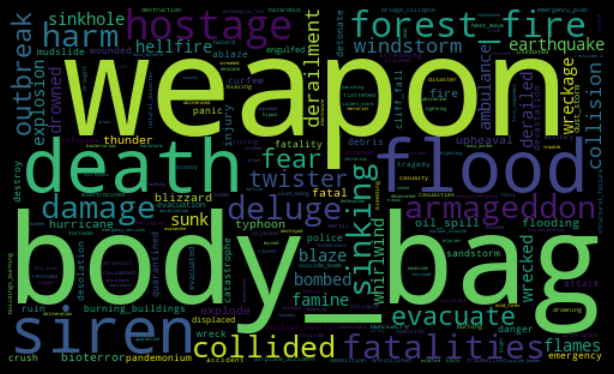

In [30]:
text = ' '.join(train.keyword.dropna().values).replace("%20", "_")
wordcloud = WordCloud(
    width = 500,
    height = 300,
    background_color = 'black',
    collocations=False,
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (10, 5),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [31]:
train.location.value_counts().reset_index().rename(columns={'location':'N'})

,index,N
0,USA,104
1,New York,71
2,United States,50
3,London,45
4,Canada,29
...,...,...
3336,U.S,1
3337,Gloucester,1
3338,oklahoma,1
3339,Wrex,1


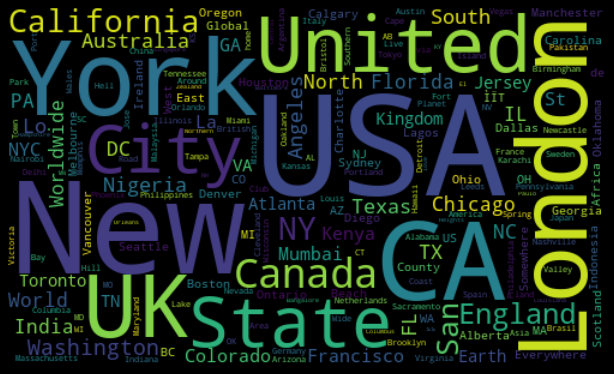

In [32]:
text = ' '.join(train.location.dropna().str.strip().replace(' ', "_").values).replace("%20", "_")
wordcloud = WordCloud(
    width = 500,
    height = 300,
    background_color = 'black',
    collocations=False,
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (10, 5),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Count if we have any retweets

In [33]:
temp = train.text.value_counts().reset_index()
temp = temp[temp.text > 1]
print(str(temp.shape[0]) + " unique texts - " + str(temp.text.sum()) + " tweets - " + str(np.round(temp.text.sum()/train.shape[0]*100, 2)) + "% of train data")

69 unique texts - 179 tweets - 2.35% of train data


## 2.1 Check to see if there are any big differences in disaster tweets and non-disaster tweets

In [34]:
list(set(train[train.target == 1].text_clean.values))[:10]

['40 families affected fatal outbreak legionnaires disease edinburgh sue two comp xurl',
 'truck ablaze r21 voortrekker ave outside tambo intl cargo section xurl',
 'free hailstorm maxi xurl',
 'kosciusko police investigating pedestrian fatality hit train thursday xurl',
 'police kill hatchetwielding gunman opened fire inside nashville movie theater amiddleaged manarmed wi xurl',
 'south sac florin rd franklin blvd trfc collision1141 enrt xurl',
 'california 039monster 039 fire 20 contained 13000 told evacuate xurl',
 'men escape car engulfed flames parleys canyon crews investigating cause xurlxurl',
 'couple storms near guthrie ok leaving norman evening lightning op okwx xurl',
 'least 180 dead million displaced india floods india reliefweb xurl']

In [35]:
list(set(train[train.target == 0].text_clean.values))[:10]

['wwi wwii japanese army navy military japan leather watch war mido ww1 2 full read ebay xurlxurl',
 'la startup hot flowers come straight volcano xurlvia xmention',
 'disillusioned lead character check happy go lucky free spirit girl check dream life crushed check great music check crowe tropes intact',
 'already phone updated 84 somehow phone crashed restore theyre letting restore',
 'photo forrestmankins colorado camping xurl',
 'swea feels like im explode',
 'ever since facebook mets meltdown padres fiasco mets 60 youre welcome',
 'yes 2 guns',
 'certainly xmention great see hs2 astroturfers panicking thought cross party support crumbling',
 'ways video stretcher xmention']

### 2.1.2 Check tweet length

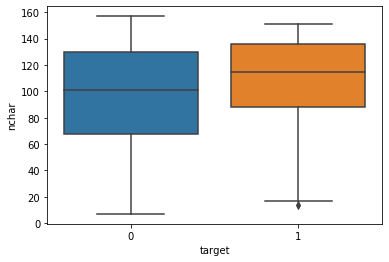

In [36]:
train['nchar'] = [len(t) for t in train.text.values]
# print(train.nchar.describe())
# print(train[train.target == 0].nchar.describe())
# print(train[train.target == 1].nchar.describe())
# sns.distplot(train[train.target == 0][['nchar']], hist=False, rug=True)
# sns.distplot(train[train.target == 1][['nchar']], hist=False, rug=True)
sns.boxplot(x="target", y = "nchar", data=train)
plt.show()

We can see that Disaster tweets tend to be longer than Non-disaster tweets. There are also some tweets with more than 140 characters, this is because of the use of emojis.

In [37]:
print(train[train.nchar > 150].text.values)
print()
print(train[train.nchar > 150].text_clean.values)

['@CAgov If 90BLKs&amp;8WHTs colluded 2 take WHT F @USAgov AUTH Hostage&amp;2 make her look BLK w/Bioterrorism&amp;use her lgl/org IDis ID still hers?@VP'
 "when you're taking a shower and someone flushes the toilet and you have .1 second to GTFO or you get burned??????????????????????????????????????????????????"
 "It's was about 2:30 in the morning&amp;I went downstairs to watch some telly&amp;I accidentally made a loud bang&amp;my dad(who has a broken leg)walked-"
 '_\r\n?????RETWEET\r\n???????\r\n?????FOLLOW ALL WHO RT\r\n???????\r\n?????FOLLOWBACK\r\n???????\r\n?????GAIN WITH \r\n???????\r\n?????FOLLOW ?@ganseyman #RT_4_A_MENTION\r\n#TY']

['xmention 90blks 8whts colluded 2 take wht f xmention auth hostage 2 make look blk bioterrorism use lglorg idis id still hersxmention'
 'youre taking shower someone flushes toilet 1 second gtfo get burned'
 '230 morning went downstairs watch telly accidentally made loud bang dadwho broken legwalked'
 'retweet follow rt followback gain follow xm

### 2.1.3 VADER Sentiment

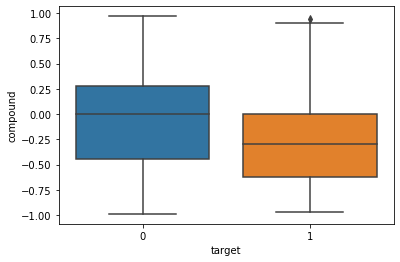

In [38]:
# import nltk
# nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

train['sid'] = [sid.polarity_scores(t) for t in train.text_clean.values]
train['compound'] = [d['compound'] for d in train.sid.values]

sns.boxplot(x='target', y='compound', data=train)

Ok, so we can see that VADER detects the disaster tweets as more negative than the non disaster tweets

## 2.2 Tokenizing text

In [39]:
count_vect = CountVectorizer()
texts = train['text_clean'].values
temp = count_vect.fit_transform(texts)
temp.shape

(7613, 15647)

In [40]:
tfidf_transformer = TfidfTransformer()
temp_2 = tfidf_transformer.fit_transform(temp)
temp_2.shape

(7613, 15647)

In [41]:
vectorizer = TfidfVectorizer()
temp_vect = vectorizer.fit_transform(texts)
temp_vect.shape

(7613, 15647)

In [42]:
train['tokens'] = train.text_clean.apply(lambda t:word_tokenize(t))
# train['tokens'] = train['tokens'].values[0]
# train[['tokens']].values[0][0]

In [43]:
train['tokens'].values

array([list(['deeds', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'us']),
       list(['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada']),
       list(['residents', 'asked', 'shelter', 'place', 'notified', 'officers', 'evacuation', 'shelter', 'place', 'orders', 'expected']),
       ..., list(['m194', '0104', 'utc5km', 'volcano', 'hawaii', 'xurl']),
       list(['police', 'investigating', 'ebike', 'collided', 'car', 'little', 'portugal', 'ebike', 'rider', 'suffered', 'serious', 'nonlife', 'threatening', 'injuries']),
       list(['latest', 'homes', 'razed', 'northern', 'california', 'wildfire', 'abc', 'news', 'xurl'])],
      dtype=object)

In [44]:
train.text_clean.values[0], train.text.values[0] 

('deeds reason earthquake may allah forgive us',
 'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all')

# 3. Train/test split and Model Creation

In [45]:
tweet_train, tweet_test, target_train, target_test = train_test_split(train['text_clean'], train['target'], test_size=0.25, random_state=42)

print("Train Features\t: " + str(tweet_train.shape))
print("Train Target\t: " + str(target_train.shape) + "\tLabel 1 (%): " + str(np.round(target_train.sum()/target_train.shape[0]*100, 2)))
print("Test Features\t: " + str(tweet_test.shape))
print("Test Target\t: " + str(target_test.shape) + "\tLabel 1 (%): " + str(np.round(target_test.sum()/target_test.shape[0]*100, 2)))


Train Features	: (5709,)
Train Target	: (5709,)	Label 1 (%): 43.05
Test Features	: (1904,)
Test Target	: (1904,)	Label 1 (%): 42.7


### 3.1 SVC

In [46]:
#SVM parameters
parameteres = {'classifier__C':[0.001,0.1,10,100], 'classifier__gamma':[0.1,0.01], 
              'classifier__kernel': ['linear', 'poly', 'rbf']}

pipeline_svc = Pipeline([
    #('bag_of_words', CountVectorizer(analyzer = text_preprocess)), 
    ('tfidf', TfidfVectorizer()),
     ('classifier', SVC()),
#    ('classifier', LogisticRegression())
])

grid_svc = GridSearchCV(pipeline_svc, param_grid=parameteres, cv = 4, 
                        scoring='accuracy', n_jobs=2, verbose=2) 

print("Model initialized====")

grid_svc.fit(tweet_train, target_train)

print("Model trained====")


#Get the scores
print ("score = %3.2f" %(grid_svc.score(tweet_test,target_test)))
print (grid_svc.best_params_)

Model initialized====
Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   58.4s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:  2.3min finished


Model trained====
score = 0.80
{'classifier__C': 10, 'classifier__gamma': 0.1, 'classifier__kernel': 'rbf'}


In [47]:
predictions = grid_svc.predict(tweet_test)
print(classification_report(target_test, predictions))
print(confusion_matrix(target_test, predictions))
print(accuracy_score(target_test, predictions))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      1091
           1       0.78      0.75      0.76       813

    accuracy                           0.80      1904
   macro avg       0.80      0.79      0.80      1904
weighted avg       0.80      0.80      0.80      1904

[[917 174]
 [205 608]]
0.8009453781512605


In [48]:
grid_svc.predict(["this forest fire is scary"])

array([1], dtype=int64)

## 3.2 MultinomialNB

In [49]:
#MultinomialNB parameters
parameteres = {'classifier__alpha':[0.001,0.1,0.25, 0.5, 0.75, 0.8, 0.9, 1]}

pipeline_mnb = Pipeline([
    #('bag_of_words', CountVectorizer(analyzer = text_preprocess)), 
    ('tfidf', TfidfVectorizer()),
     ('classifier', MultinomialNB())
])

grid_mnb = GridSearchCV(pipeline_mnb, param_grid=parameteres, cv = 4, 
                        scoring='accuracy', n_jobs=2, verbose=5) 

print("Model initialized====")

grid_mnb.fit(tweet_train, target_train)

print("Model trained====")


#Get the scores
print ("score = %3.2f" %(grid_mnb.score(tweet_test,target_test)))
print (grid_mnb.best_params_)

Model initialized====
Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    1.1s


Model trained====
score = 0.80
{'classifier__alpha': 0.5}


[Parallel(n_jobs=2)]: Done  32 out of  32 | elapsed:    2.4s finished


In [50]:
predictions = grid_mnb.predict(tweet_test)
print(classification_report(target_test, predictions))
print(confusion_matrix(target_test, predictions))
print(accuracy_score(target_test, predictions))
print(grid_mnb.predict(["this forest fire is scary"]))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84      1091
           1       0.82      0.70      0.75       813

    accuracy                           0.80      1904
   macro avg       0.81      0.79      0.79      1904
weighted avg       0.80      0.80      0.80      1904

[[964 127]
 [247 566]]
0.8035714285714286
[1]


### 3.3 Logistic Regression

In [51]:
#Logistic Regression parameters
parameteres = {'classifier__C':[0.001,0.1,0.25, 0.5, 0.75, 0.8, 0.9, 1.0], 
              'classifier__solver':['newton-cg', 'sag', 'lbfgs'], 
              'classifier__max_iter':[100,200,500,1000]}

pipeline_lr = Pipeline([
    #('bag_of_words', CountVectorizer(analyzer = text_preprocess)), 
    ('tfidf', TfidfVectorizer()),
     ('classifier', LogisticRegression())
])

grid_lr = GridSearchCV(pipeline_lr, param_grid=parameteres, cv = 4, 
                        scoring='accuracy', n_jobs=2, verbose=5) 

print("Model initialized====")

grid_lr.fit(tweet_train, target_train)

print("Model trained====")


#Get the scores
print ("score = %3.2f" %(grid_lr.score(tweet_test,target_test)))
print (grid_lr.best_params_)

Model initialized====
Fitting 4 folds for each of 96 candidates, totalling 384 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:    8.1s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   17.4s
[Parallel(n_jobs=2)]: Done 284 tasks      | elapsed:   31.4s
[Parallel(n_jobs=2)]: Done 384 out of 384 | elapsed:   42.6s finished


Model trained====
score = 0.81
{'classifier__C': 1.0, 'classifier__max_iter': 100, 'classifier__solver': 'newton-cg'}


In [52]:
predictions = grid_lr.predict(tweet_test)
print(classification_report(target_test, predictions))
print(confusion_matrix(target_test, predictions))
print(accuracy_score(target_test, predictions))
print(grid_lr.predict(["this forest fire is scary"]))

              precision    recall  f1-score   support

           0       0.80      0.90      0.85      1091
           1       0.84      0.69      0.76       813

    accuracy                           0.81      1904
   macro avg       0.82      0.80      0.80      1904
weighted avg       0.81      0.81      0.81      1904

[[982 109]
 [249 564]]
0.8119747899159664
[1]


### 3.4 Random Forest

In [53]:
#Logistic Regression parameters
parameteres = {
    'tfidf__max_features':[2000],
 'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3)],
 'classifier__max_depth': [1000],
 'classifier__min_samples_split': [10, 50, 100],
 'classifier__max_leaf_nodes': [None]}

pipeline_rf = Pipeline([
    #('bag_of_words', CountVectorizer(analyzer = text_preprocess)), 
    ('tfidf', TfidfVectorizer()),
     ('classifier', RandomForestClassifier())
])

grid_rf = GridSearchCV(pipeline_rf, param_grid=parameteres, cv = 4, 
                        scoring='accuracy', n_jobs=2, verbose=5) 

print("Model initialized====")

grid_rf.fit(tweet_train, target_train)

print("Model trained====")


#Get the scores
print ("score = %3.2f" %(grid_rf.score(tweet_test,target_test)))
print (grid_rf.best_params_)

Model initialized====
Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    3.7s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:   17.0s
[Parallel(n_jobs=2)]: Done  72 out of  72 | elapsed:   18.0s finished
C:\Users\94198013\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Model trained====
score = 0.76
{'classifier__max_depth': 1000, 'classifier__max_leaf_nodes': None, 'classifier__min_samples_split': 50, 'tfidf__max_features': 2000, 'tfidf__ngram_range': (1, 3)}


In [54]:
predictions = grid_rf.predict(tweet_test)
print(classification_report(target_test, predictions))
print(confusion_matrix(target_test, predictions))
print(accuracy_score(target_test, predictions))
print(grid_rf.predict(["this forest fire is scary"]))

              precision    recall  f1-score   support

           0       0.76      0.85      0.80      1091
           1       0.76      0.65      0.70       813

    accuracy                           0.76      1904
   macro avg       0.76      0.75      0.75      1904
weighted avg       0.76      0.76      0.76      1904

[[927 164]
 [287 526]]
0.7631302521008403
[1]


## 4. Save Models

In [55]:
# joblib.dump(grid_lr, 'grid_lr.pkl')
# joblib.dump(grid_mnb, 'grid_mnb.pkl')
# joblib.dump(grid_rf, 'grid_rf.pkl')
# joblib.dump(grid_svc, 'grid_svc.pkl')

## 5. Make predictions on the submission

In [56]:
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [58]:
test['text_clean'] = [text_preprocess(t) for t in test.text.values]
test.head()

,id,keyword,location,text,text_clean
0,0,NaN,NaN,Just happened a terrible car crash,happened terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard earthquake different cities stay safe ev...
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese fleeing across str...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills 28 china taiwan


In [60]:
test['target'] = [grid_lr.predict([t])[0] for t in test.text_clean.values]
test.head()

,id,keyword,location,text,text_clean,target
0,0,NaN,NaN,Just happened a terrible car crash,happened terrible car crash,1
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard earthquake different cities stay safe ev...,1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese fleeing across str...,1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires,0
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills 28 china taiwan,1


In [63]:
my_submission = test[['id', 'target']]
my_submission.to_csv("my_submission_" + str(datetime.now()).replace(":", "").replace(" ", "") +".csv", index=False )